# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import seaborn as sns
# import opendatasets as od
import pandas as pd
# import torch
# from torchvision import transforms
# from PIL import Image
# import cv2
import numpy as np
# from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def get_y_pred(model, test_dataloader, device):
    model.eval()
    y_pred = []

    with torch.no_grad():
        for X, _ in tqdm(test_dataloader):
            X = X.to(device)

            # Forward pass
            output = model(X)


            # Get the predicted labels
            if output.ndim == 1:
              output = output.unsqueeze(0)

            _, predicted = torch.max(output, dim=1)

            y_pred.append(predicted.cpu())

    y_pred = torch.cat(y_pred, dim=0)
    return y_pred

In [ ]:
from tqdm.auto import tqdm
import torch

def train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs, device, PATH):

  # Send model to device
  model = model.to(device)

  train_losses, test_losses = [], []
  train_accies, test_accies = [], []
  best_acc = 0

  for epoch in range(epochs):

    train_loss, test_loss = 0, 0
    train_acc, test_acc = 0, 0

    ### Train ###
    model.train()

    for X, y in tqdm(train_dataloader):

      # Send data to device
      X, y = X.to(device), y.to(device)

      # Forwad pass
      outputs = model(X)
      loss = criterion(outputs, y)
      optimizer.zero_grad() # Xóa cái optimizer ở vòng lặp trước

      # Calculate loss per batch
      train_loss += loss.item()
      train_acc += (outputs.argmax(dim=1)==y).sum().item() / len(y)

      # Optimizer & Backward
      loss.backward() #
      optimizer.step() # update weight

    ### Evaluate ###
    model.eval()
    with torch.inference_mode():

      for X, y in tqdm(test_dataloader):

        # Send data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Calculate loss per batch
        test_loss += loss.item()
        test_acc += (outputs.argmax(dim=1)==y).sum().item() / len(y)

    # Save stuff
    train_loss, train_acc = train_loss/len(train_dataloader), train_acc/len(train_dataloader)
    test_loss, test_acc = test_loss/len(test_dataloader), test_acc/len(test_dataloader)

    train_losses.append(train_loss), train_accies.append(train_acc)
    test_losses.append(test_loss), test_accies.append(test_acc)

    # Tracking the model
    print(f'Epoch: {epoch}| Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}| Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

    # Save the model
    if best_acc < test_acc:
      torch.save(model, PATH)
      best_acc = test_acc

  return train_losses, train_accies, test_losses, test_accies

In [ ]:
def plot_evaluate(y_true, y_pred):
    plt.figure(figsize=(6, 4))
    print(classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', linewidths=1, annot=True, fmt='g');

# Model

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self, color_channels, hidden_size, output_size):
    super().__init__()

    self.features = nn.Sequential(
            nn.Conv2d(in_channels=color_channels, out_channels=hidden_size, kernel_size=3),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),

            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),

            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.classifier = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.features(x)
    x = self.avg_pool(x)
    return self.classifier(x.squeeze())

# APTOS2019

In [ ]:
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-raw.pt')

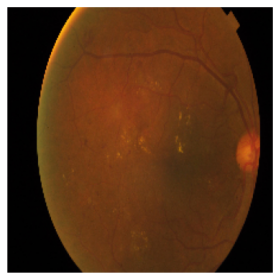

In [ ]:
plt.imshow(raw_data.tensors[0][0].permute(1, 2, 0))
plt.axis(False);

In [ ]:
cc_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-circle-crop.pt')

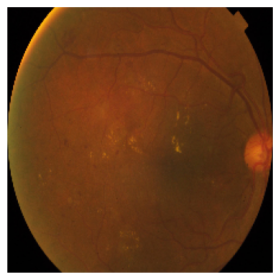

In [ ]:
plt.imshow(cc_data.tensors[0][0].permute(1, 2, 0))
plt.axis(False);

In [ ]:
bens_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-bens.pt')

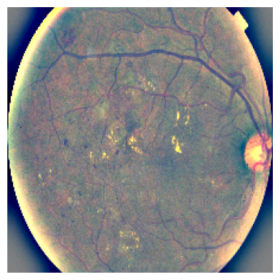

In [ ]:
plt.imshow(bens_data.tensors[0][0].permute(1, 2, 0))
plt.axis(False);

## Raw Data

In [ ]:
# Load dataset
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-raw.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

(torch.Size([2453, 3, 224, 224]),
 torch.Size([399, 3, 224, 224]),
 torch.Size([810, 3, 224, 224]))

In [ ]:
# Call the model
torch.manual_seed(42)
model = SimpleCNN(3, 256, len(y_train.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, train_accies, test_losses, test_accies = train(model,
                                                             train_dataloader,
                                                             valid_dataloader,
                                                             criterion,
                                                             optimizer,
                                                             20,
                                                             device,
                                                             '/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-raw.pt')

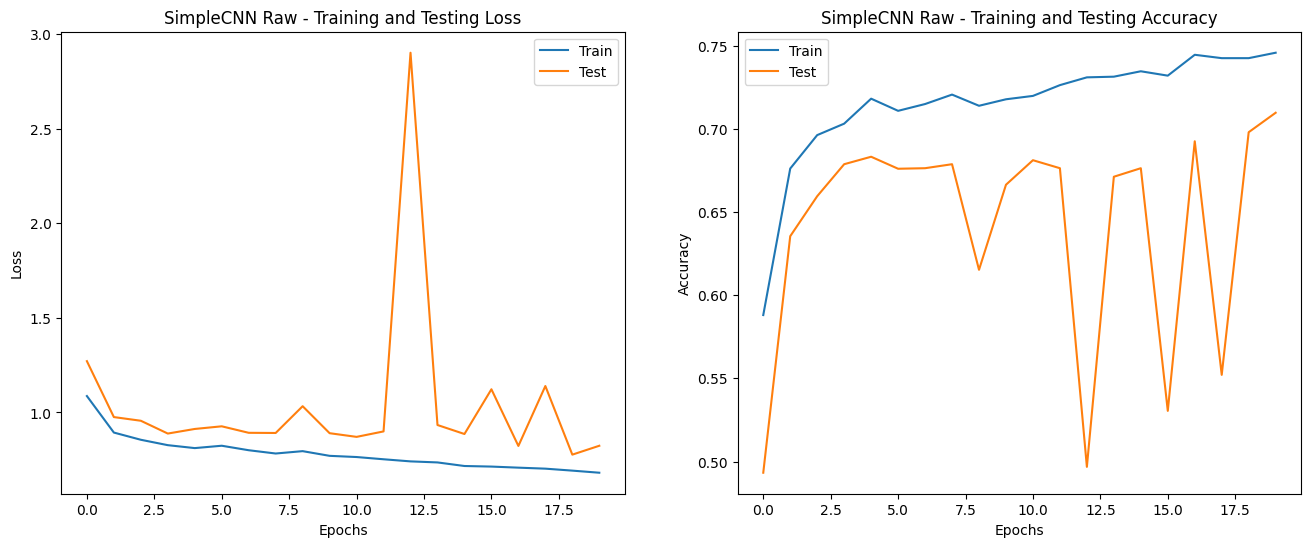

In [ ]:
# Plot the valid, train accuracy and loss (THIS IS VALID NOT TEST)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SimpleCNN Raw - Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accies, label='Train')
plt.plot(test_accies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleCNN Raw - Training and Testing Accuracy')
plt.legend()
plt.show()

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       396
           1       0.42      0.44      0.43        73
           2       0.61      0.76      0.68       231
           3       0.67      0.05      0.09        41
           4       0.00      0.00      0.00        69

    accuracy                           0.74       810
   macro avg       0.52      0.45      0.43       810
weighted avg       0.68      0.74      0.69       810



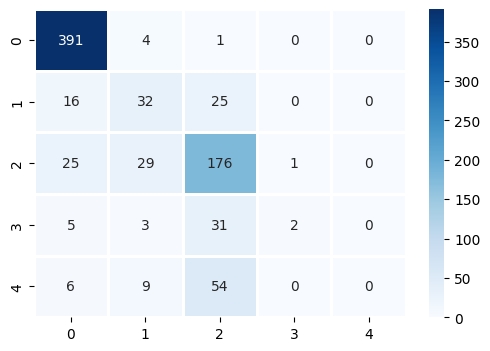

In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-raw.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
plot_evaluate(y_true, y_pred)

## Circle Crop

In [ ]:
# Load dataset
circle_crop_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-circle-crop.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(circle_crop_data.tensors[0], circle_crop_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([2453, 3, 224, 224]) torch.Size([399, 3, 224, 224]) torch.Size([810, 3, 224, 224])


In [ ]:
# Call the model
torch.manual_seed(42)
model = SimpleCNN(3, 256, len(y_train.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, train_accies, test_losses, test_accies = train(model,
                                                             train_dataloader,
                                                             valid_dataloader,
                                                             criterion,
                                                             optimizer,
                                                             20,
                                                             device,
                                                             '/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-circle-crop.pt')

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 0| Train loss: 1.0313, Train acc: 0.6327| Test loss: 1.1306, Test acc: 0.5729


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.8898, Train acc: 0.6838| Test loss: 1.0166, Test acc: 0.6114


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 2| Train loss: 0.8549, Train acc: 0.6998| Test loss: 1.0057, Test acc: 0.6543


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 3| Train loss: 0.8241, Train acc: 0.7049| Test loss: 0.9459, Test acc: 0.6667


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 4| Train loss: 0.8233, Train acc: 0.7118| Test loss: 0.9359, Test acc: 0.6787


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 5| Train loss: 0.8253, Train acc: 0.7053| Test loss: 0.9387, Test acc: 0.6787


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 6| Train loss: 0.8073, Train acc: 0.7108| Test loss: 1.0040, Test acc: 0.6643


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 7| Train loss: 0.7895, Train acc: 0.7223| Test loss: 0.9032, Test acc: 0.6787


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 8| Train loss: 0.8004, Train acc: 0.7169| Test loss: 0.9270, Test acc: 0.6519


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 9| Train loss: 0.7772, Train acc: 0.7157| Test loss: 0.9336, Test acc: 0.6663


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10| Train loss: 0.7726, Train acc: 0.7159| Test loss: 0.8746, Test acc: 0.6859


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 11| Train loss: 0.7683, Train acc: 0.7252| Test loss: 0.9150, Test acc: 0.6615


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12| Train loss: 0.7636, Train acc: 0.7270| Test loss: 0.9023, Test acc: 0.6835


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 13| Train loss: 0.7604, Train acc: 0.7250| Test loss: 1.0380, Test acc: 0.6300


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14| Train loss: 0.7495, Train acc: 0.7309| Test loss: 0.8330, Test acc: 0.6687


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 15| Train loss: 0.7622, Train acc: 0.7197| Test loss: 1.5164, Test acc: 0.5136


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 16| Train loss: 0.7449, Train acc: 0.7291| Test loss: 0.8633, Test acc: 0.6955


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 17| Train loss: 0.7459, Train acc: 0.7215| Test loss: 1.0068, Test acc: 0.5644


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 18| Train loss: 0.7257, Train acc: 0.7317| Test loss: 0.8127, Test acc: 0.6883


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 19| Train loss: 0.7201, Train acc: 0.7414| Test loss: 0.8068, Test acc: 0.6883


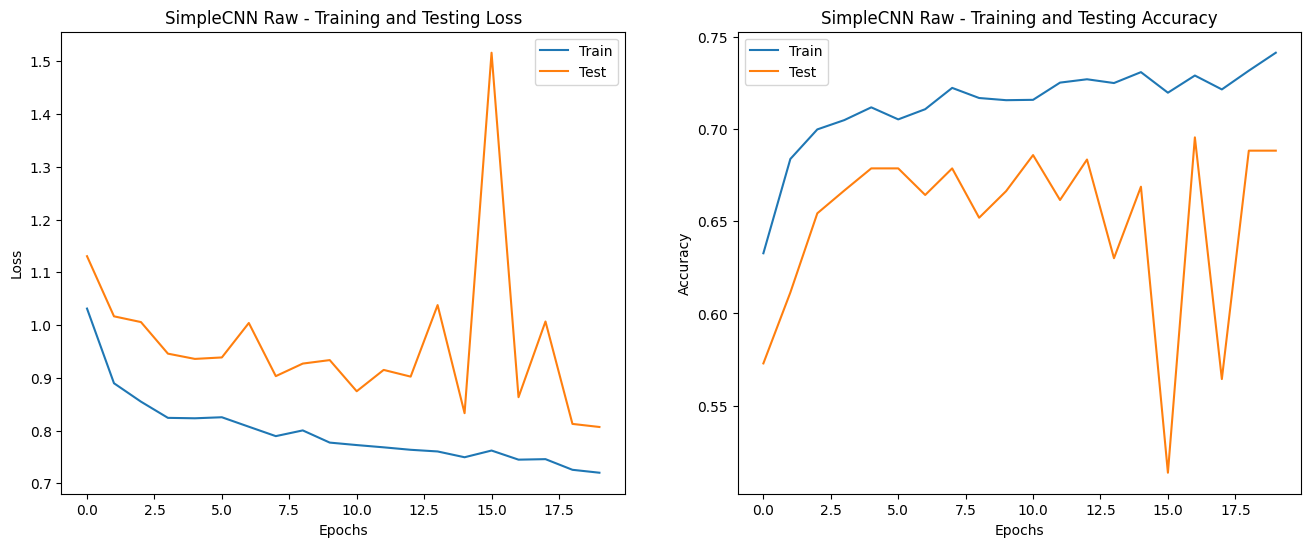

In [ ]:
# Plot the valid, train accuracy and loss (THIS IS VALID NOT TEST)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SimpleCNN Raw - Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accies, label='Train')
plt.plot(test_accies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleCNN Raw - Training and Testing Accuracy')
plt.legend()
plt.show()

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       396
           1       0.40      0.16      0.23        73
           2       0.55      0.81      0.65       231
           3       0.14      0.12      0.13        41
           4       0.00      0.00      0.00        69

    accuracy                           0.72       810
   macro avg       0.41      0.41      0.39       810
weighted avg       0.66      0.72      0.68       810



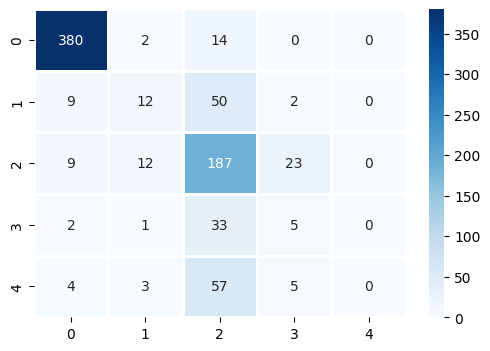

In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-circle-crop.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
plot_evaluate(y_true, y_pred)

## Bens Graham

In [ ]:
del circle_crop_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# Load dataset
bens_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-bens.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(bens_data.tensors[0], bens_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([2453, 3, 224, 224]) torch.Size([399, 3, 224, 224]) torch.Size([810, 3, 224, 224])


In [ ]:
# Call the model
torch.manual_seed(42)
model = SimpleCNN(3, 256, len(y_train.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, train_accies, test_losses, test_accies = train(model,
                                                             train_dataloader,
                                                             valid_dataloader,
                                                             criterion,
                                                             optimizer,
                                                             20,
                                                             device,
                                                             '/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-bens.pt')

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 0| Train loss: 0.9196, Train acc: 0.6664| Test loss: 0.9716, Test acc: 0.6258


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.7790, Train acc: 0.7141| Test loss: 4.9121, Test acc: 0.4824


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 2| Train loss: 0.7257, Train acc: 0.7339| Test loss: 1.2166, Test acc: 0.6763


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 3| Train loss: 0.6850, Train acc: 0.7416| Test loss: 1.2085, Test acc: 0.5623


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 4| Train loss: 0.6722, Train acc: 0.7408| Test loss: 0.8052, Test acc: 0.7027


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 5| Train loss: 0.6635, Train acc: 0.7518| Test loss: 2.2664, Test acc: 0.5043


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 6| Train loss: 0.6356, Train acc: 0.7674| Test loss: 2.4955, Test acc: 0.4896


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 7| Train loss: 0.6176, Train acc: 0.7666| Test loss: 1.7073, Test acc: 0.6763


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 8| Train loss: 0.6245, Train acc: 0.7700| Test loss: 5.3006, Test acc: 0.2516


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 9| Train loss: 0.6017, Train acc: 0.7757| Test loss: 4.0073, Test acc: 0.2684


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10| Train loss: 0.5791, Train acc: 0.7774| Test loss: 1.2720, Test acc: 0.6062


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 11| Train loss: 0.5733, Train acc: 0.7810| Test loss: 1.4907, Test acc: 0.6667


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12| Train loss: 0.5663, Train acc: 0.7835| Test loss: 1.1058, Test acc: 0.7027


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 13| Train loss: 0.5732, Train acc: 0.7784| Test loss: 6.0344, Test acc: 0.1476


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14| Train loss: 0.5696, Train acc: 0.7877| Test loss: 2.4114, Test acc: 0.5167


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 15| Train loss: 0.5721, Train acc: 0.7792| Test loss: 0.7272, Test acc: 0.7367


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 16| Train loss: 0.5477, Train acc: 0.7950| Test loss: 1.3003, Test acc: 0.5702


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 17| Train loss: 0.5503, Train acc: 0.7996| Test loss: 1.7101, Test acc: 0.6231


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 18| Train loss: 0.5344, Train acc: 0.7976| Test loss: 1.0187, Test acc: 0.6303


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 19| Train loss: 0.5353, Train acc: 0.8053| Test loss: 1.3357, Test acc: 0.6327


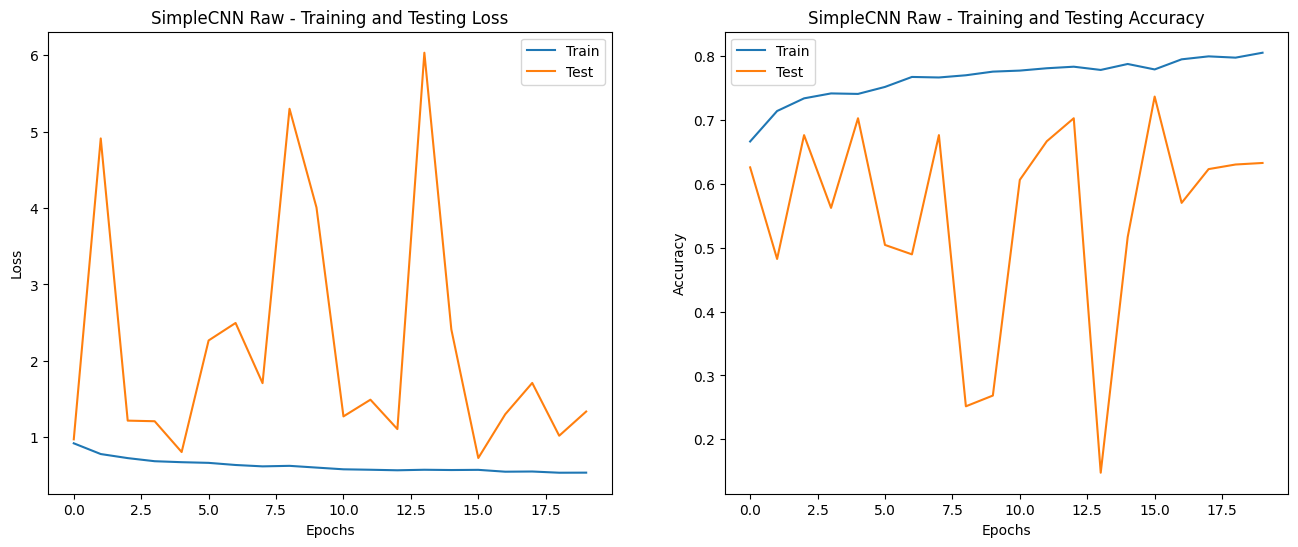

In [ ]:
# Plot the valid, train accuracy and loss (THIS IS VALID NOT TEST)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SimpleCNN Raw - Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accies, label='Train')
plt.plot(test_accies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleCNN Raw - Training and Testing Accuracy')
plt.legend()
plt.show()

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.70      0.99      0.82       396
           1       0.00      0.00      0.00        73
           2       0.50      0.00      0.01       231
           3       0.12      0.71      0.20        41
           4       0.00      0.00      0.00        69

    accuracy                           0.52       810
   macro avg       0.26      0.34      0.21       810
weighted avg       0.49      0.52      0.41       810



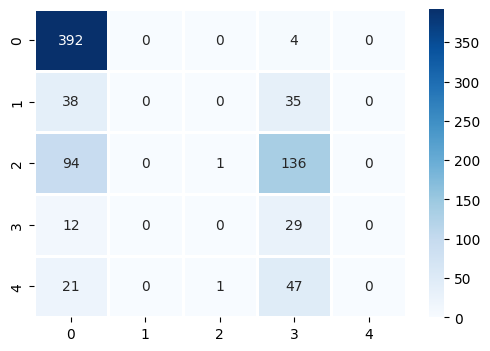

In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-circle-crop.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
plot_evaluate(y_true, y_pred)

# MESSIDOR2

## Raw

In [ ]:
del bens_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# Load dataset
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/messidor-2-raw.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([1168, 3, 224, 224]) torch.Size([191, 3, 224, 224]) torch.Size([385, 3, 224, 224])


In [ ]:
# Call the model
torch.manual_seed(42)
model = SimpleCNN(3, 256, len(y_train.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, train_accies, test_losses, test_accies = train(model,
                                                             train_dataloader,
                                                             valid_dataloader,
                                                             criterion,
                                                             optimizer,
                                                             20,
                                                             device,
                                                             '/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-raw.pt')

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0| Train loss: 1.1754, Train acc: 0.5481| Test loss: 1.1009, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.0730, Train acc: 0.5684| Test loss: 1.0337, Test acc: 0.6016


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2| Train loss: 1.0558, Train acc: 0.5845| Test loss: 1.0282, Test acc: 0.5919


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3| Train loss: 1.0578, Train acc: 0.5845| Test loss: 1.0178, Test acc: 0.5917


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4| Train loss: 1.0589, Train acc: 0.5802| Test loss: 1.0499, Test acc: 0.5598


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5| Train loss: 1.0407, Train acc: 0.5938| Test loss: 1.0486, Test acc: 0.5341


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6| Train loss: 1.0445, Train acc: 0.5819| Test loss: 1.0081, Test acc: 0.5862


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7| Train loss: 1.0371, Train acc: 0.5887| Test loss: 1.0340, Test acc: 0.5914


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8| Train loss: 1.0411, Train acc: 0.5929| Test loss: 1.0298, Test acc: 0.6072


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9| Train loss: 1.0246, Train acc: 0.5912| Test loss: 1.0916, Test acc: 0.5707


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10| Train loss: 1.0280, Train acc: 0.5946| Test loss: 1.0570, Test acc: 0.5917


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11| Train loss: 1.0411, Train acc: 0.5912| Test loss: 1.0653, Test acc: 0.5813


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12| Train loss: 1.0321, Train acc: 0.5887| Test loss: 1.0179, Test acc: 0.6023


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13| Train loss: 1.0313, Train acc: 0.5777| Test loss: 1.0264, Test acc: 0.5914


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14| Train loss: 1.0341, Train acc: 0.5802| Test loss: 1.0550, Test acc: 0.5761


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15| Train loss: 1.0361, Train acc: 0.5929| Test loss: 1.0115, Test acc: 0.5966


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16| Train loss: 1.0261, Train acc: 0.5904| Test loss: 1.0471, Test acc: 0.5758


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17| Train loss: 1.0288, Train acc: 0.5878| Test loss: 1.0290, Test acc: 0.5864


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18| Train loss: 1.0267, Train acc: 0.5904| Test loss: 1.0261, Test acc: 0.6022


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19| Train loss: 1.0186, Train acc: 0.5828| Test loss: 1.0328, Test acc: 0.5707


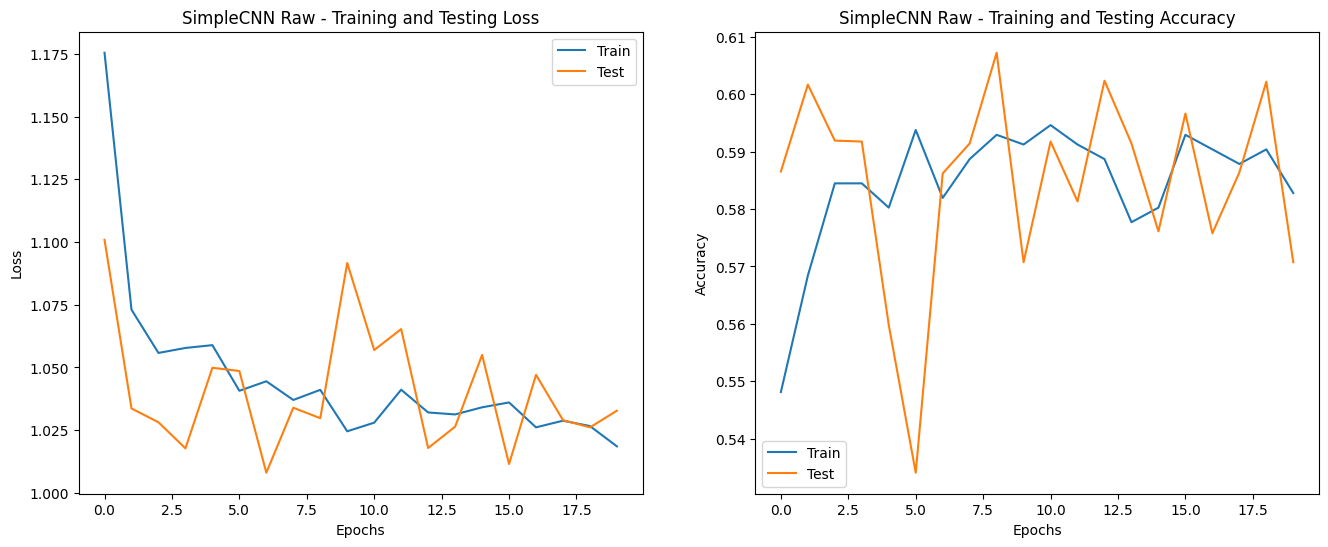

In [ ]:
# Plot the valid, train accuracy and loss (THIS IS VALID NOT TEST)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SimpleCNN Raw - Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accies, label='Train')
plt.plot(test_accies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleCNN Raw - Training and Testing Accuracy')
plt.legend()
plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.70      0.89      0.78       236
           1       0.50      0.02      0.04        53
           2       0.29      0.35      0.32        71
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         7

    accuracy                           0.61       385
   macro avg       0.30      0.25      0.23       385
weighted avg       0.55      0.61      0.54       385



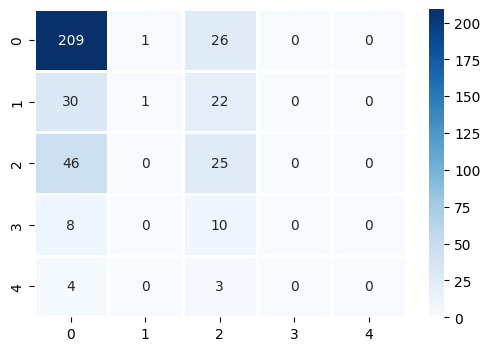

In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-raw.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
plot_evaluate(y_true, y_pred)

## Circle Crop

In [ ]:
del bens_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# Load dataset
circle_crop_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/messidor-2-circle-crop.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(circle_crop_data.tensors[0], circle_crop_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([1168, 3, 224, 224]) torch.Size([191, 3, 224, 224]) torch.Size([385, 3, 224, 224])


In [ ]:
# Call the model
torch.manual_seed(42)
model = SimpleCNN(3, 256, len(y_train.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, train_accies, test_losses, test_accies = train(model,
                                                             train_dataloader,
                                                             valid_dataloader,
                                                             criterion,
                                                             optimizer,
                                                             20,
                                                             device,
                                                             '/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-circle-crop.pt')

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0| Train loss: 1.1993, Train acc: 0.5372| Test loss: 1.0941, Test acc: 0.5864


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.0797, Train acc: 0.5752| Test loss: 1.0471, Test acc: 0.6018


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2| Train loss: 1.0623, Train acc: 0.5760| Test loss: 1.0595, Test acc: 0.5813


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3| Train loss: 1.0753, Train acc: 0.5845| Test loss: 1.0554, Test acc: 0.5921


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4| Train loss: 1.0753, Train acc: 0.5650| Test loss: 1.0502, Test acc: 0.6018


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5| Train loss: 1.0574, Train acc: 0.5912| Test loss: 1.0759, Test acc: 0.5235


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6| Train loss: 1.0609, Train acc: 0.5802| Test loss: 1.0351, Test acc: 0.5914


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7| Train loss: 1.0491, Train acc: 0.5878| Test loss: 1.0542, Test acc: 0.5813


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8| Train loss: 1.0551, Train acc: 0.5878| Test loss: 1.0467, Test acc: 0.6122


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9| Train loss: 1.0417, Train acc: 0.5963| Test loss: 1.1107, Test acc: 0.5813


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10| Train loss: 1.0458, Train acc: 0.5912| Test loss: 1.0657, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11| Train loss: 1.0496, Train acc: 0.5853| Test loss: 1.0965, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12| Train loss: 1.0454, Train acc: 0.5878| Test loss: 1.0410, Test acc: 0.5763


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13| Train loss: 1.0437, Train acc: 0.5845| Test loss: 1.0427, Test acc: 0.5867


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14| Train loss: 1.0396, Train acc: 0.5887| Test loss: 1.2011, Test acc: 0.5761


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15| Train loss: 1.0473, Train acc: 0.5887| Test loss: 1.1223, Test acc: 0.5129


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16| Train loss: 1.0340, Train acc: 0.5819| Test loss: 1.0589, Test acc: 0.5973


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17| Train loss: 1.0325, Train acc: 0.5921| Test loss: 1.0387, Test acc: 0.6072


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18| Train loss: 1.0378, Train acc: 0.5819| Test loss: 1.0332, Test acc: 0.5919


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19| Train loss: 1.0207, Train acc: 0.5870| Test loss: 1.0303, Test acc: 0.5864


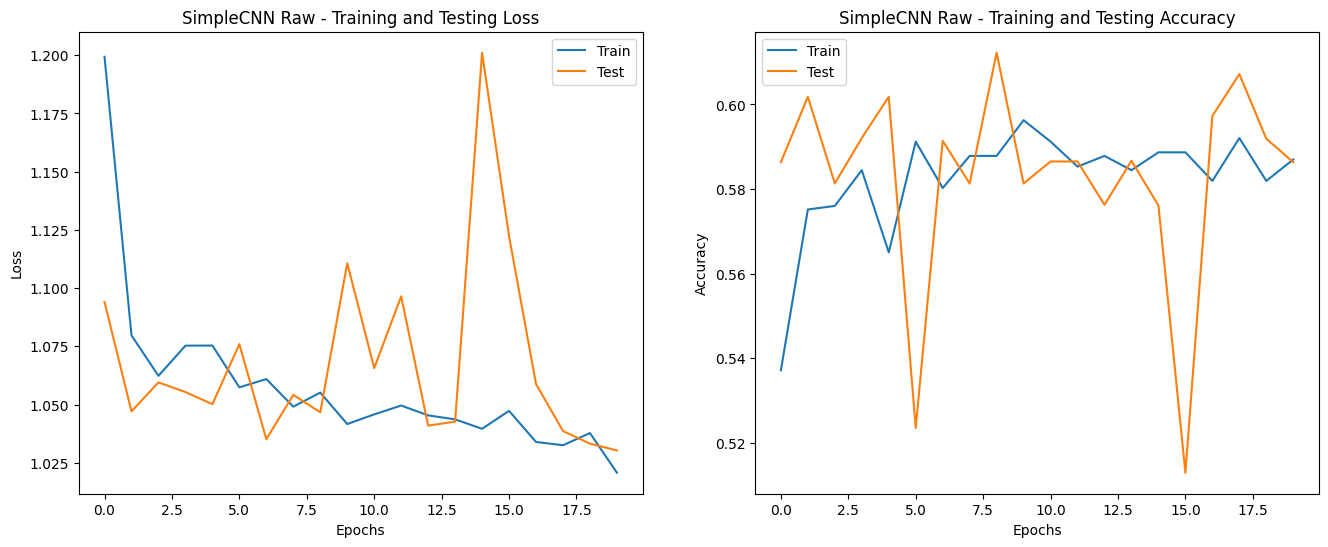

In [ ]:
# Plot the valid, train accuracy and loss (THIS IS VALID NOT TEST)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SimpleCNN Raw - Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accies, label='Train')
plt.plot(test_accies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleCNN Raw - Training and Testing Accuracy')
plt.legend()
plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.68      0.91      0.78       236
           1       0.22      0.08      0.11        53
           2       0.27      0.20      0.23        71
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         7

    accuracy                           0.61       385
   macro avg       0.23      0.24      0.22       385
weighted avg       0.50      0.61      0.54       385



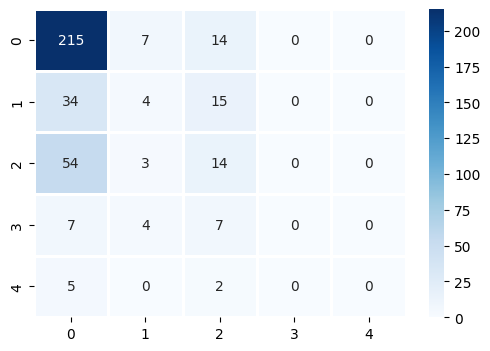

In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-circle-crop.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
plot_evaluate(y_true, y_pred)

## Ben Graham

In [ ]:
del circle_crop_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# Load dataset
bens_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/messidor-2-bens.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(bens_data.tensors[0], bens_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([1168, 3, 224, 224]) torch.Size([191, 3, 224, 224]) torch.Size([385, 3, 224, 224])


In [ ]:
# Call the model
torch.manual_seed(42)
model = SimpleCNN(3, 256, len(y_train.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, train_accies, test_losses, test_accies = train(model,
                                                             train_dataloader,
                                                             valid_dataloader,
                                                             criterion,
                                                             optimizer,
                                                             20,
                                                             device,
                                                             '/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-bens.pt')

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0| Train loss: 1.1485, Train acc: 0.5439| Test loss: 1.0861, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.0567, Train acc: 0.5785| Test loss: 0.9897, Test acc: 0.6174


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2| Train loss: 1.0456, Train acc: 0.5870| Test loss: 1.2830, Test acc: 0.5133


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3| Train loss: 1.0347, Train acc: 0.5895| Test loss: 1.1299, Test acc: 0.5917


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4| Train loss: 1.0262, Train acc: 0.6047| Test loss: 1.3512, Test acc: 0.4447


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5| Train loss: 1.0061, Train acc: 0.5980| Test loss: 2.3722, Test acc: 0.1309


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6| Train loss: 1.0136, Train acc: 0.5904| Test loss: 1.7902, Test acc: 0.2408


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7| Train loss: 0.9999, Train acc: 0.5980| Test loss: 1.0510, Test acc: 0.6178


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8| Train loss: 0.9839, Train acc: 0.6132| Test loss: 2.1429, Test acc: 0.1677


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9| Train loss: 0.9793, Train acc: 0.6064| Test loss: 1.5125, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10| Train loss: 0.9689, Train acc: 0.6132| Test loss: 1.1501, Test acc: 0.4861


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11| Train loss: 0.9754, Train acc: 0.6191| Test loss: 1.6591, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12| Train loss: 0.9635, Train acc: 0.6216| Test loss: 1.3287, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13| Train loss: 0.9576, Train acc: 0.6149| Test loss: 0.9289, Test acc: 0.6178


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14| Train loss: 0.9478, Train acc: 0.6275| Test loss: 9.2527, Test acc: 0.0210


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15| Train loss: 0.9496, Train acc: 0.6225| Test loss: 1.4323, Test acc: 0.5917


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16| Train loss: 0.9475, Train acc: 0.6047| Test loss: 1.4382, Test acc: 0.5865


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17| Train loss: 0.9290, Train acc: 0.6140| Test loss: 1.7113, Test acc: 0.5603


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18| Train loss: 0.9325, Train acc: 0.6166| Test loss: 2.4552, Test acc: 0.1359


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19| Train loss: 0.9152, Train acc: 0.6360| Test loss: 8.7604, Test acc: 0.0158


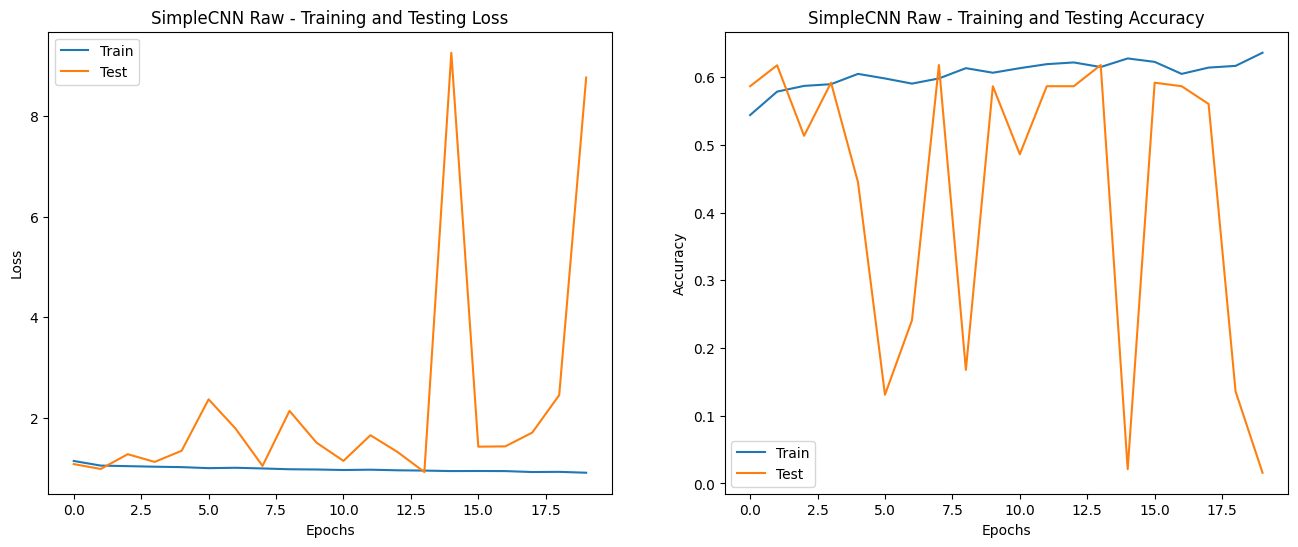

In [ ]:
# Plot the valid, train accuracy and loss (THIS IS VALID NOT TEST)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SimpleCNN Raw - Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accies, label='Train')
plt.plot(test_accies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleCNN Raw - Training and Testing Accuracy')
plt.legend()
plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.72      0.90      0.80       236
           1       0.00      0.00      0.00        53
           2       0.30      0.25      0.27        71
           3       0.10      0.17      0.13        18
           4       0.00      0.00      0.00         7

    accuracy                           0.61       385
   macro avg       0.22      0.26      0.24       385
weighted avg       0.50      0.61      0.55       385



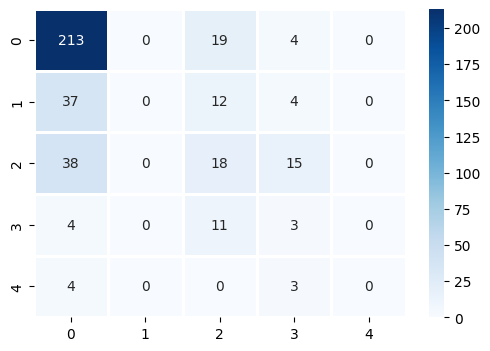

In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-bens.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
plot_evaluate(y_true, y_pred)

# Calculate the F1 score

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# APTOS2019
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-raw.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([2453, 3, 224, 224]) torch.Size([399, 3, 224, 224]) torch.Size([810, 3, 224, 224])


In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-raw.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
print(f1_score(y_true, y_pred, average='micro'))

0.612987012987013


In [ ]:
del raw_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# APTOS2019
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-circle-crop.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([2453, 3, 224, 224]) torch.Size([399, 3, 224, 224]) torch.Size([810, 3, 224, 224])


In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-circle-crop.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
print(f1_score(y_true, y_pred, average='micro'))

  0%|          | 0/26 [00:00<?, ?it/s]

0.7209876543209877


In [ ]:
del raw_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# APTOS2019
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-bens.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([2453, 3, 224, 224]) torch.Size([399, 3, 224, 224]) torch.Size([810, 3, 224, 224])


In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-aptos2019-bens.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
print(f1_score(y_true, y_pred, average='micro'))

  0%|          | 0/26 [00:00<?, ?it/s]

0.7308641975308643


In [ ]:
del raw_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# MESSIDOR2
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/messidor-2-raw.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([1168, 3, 224, 224]) torch.Size([191, 3, 224, 224]) torch.Size([385, 3, 224, 224])


In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-raw.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
print(f1_score(y_true, y_pred, average='micro'))

  0%|          | 0/13 [00:00<?, ?it/s]

0.6103896103896104


In [ ]:
del raw_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# MESSIDOR2
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/messidor-2-circle-crop.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([1168, 3, 224, 224]) torch.Size([191, 3, 224, 224]) torch.Size([385, 3, 224, 224])


In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-circle-crop.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
print(f1_score(y_true, y_pred, average='micro'))

  0%|          | 0/13 [00:00<?, ?it/s]

0.6051948051948052


In [ ]:
del raw_data
del X_train
del X_test_
del X_test
del X_valid

del train_data
del valid_data
del test_data

del model

In [ ]:
# MESSIDOR2
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/messidor-2-bens.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# To DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([1168, 3, 224, 224]) torch.Size([191, 3, 224, 224]) torch.Size([385, 3, 224, 224])


In [ ]:
model = torch.load('/content/drive/MyDrive/UIT/Hien/Model/SimpleCNN-messidor2-bens.pt').to(device)
y_pred = get_y_pred(model, test_dataloader, device)
y_true = test_data.tensors[1]
print(f1_score(y_true, y_pred, average='micro'))

  0%|          | 0/13 [00:00<?, ?it/s]

0.6077922077922078


# Augumentation

In [ ]:
# APTOS2019
raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-raw.pt')

In [ ]:
raw_data.tensors[0][0]

tensor([[[3, 3, 2,  ..., 1, 2, 3],
         [3, 3, 1,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 1, 1, 2],
         ...,
         [1, 1, 2,  ..., 2, 2, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [2, 1, 1,  ..., 3, 1, 2]],

        [[1, 1, 2,  ..., 1, 0, 1],
         [1, 1, 1,  ..., 2, 0, 0],
         [2, 2, 0,  ..., 1, 1, 2],
         ...,
         [1, 1, 2,  ..., 2, 2, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 3, 1, 2]],

        [[2, 2, 2,  ..., 1, 1, 2],
         [2, 2, 1,  ..., 2, 1, 1],
         [2, 2, 1,  ..., 1, 1, 2],
         ...,
         [1, 1, 2,  ..., 2, 2, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 3, 1, 2]]], dtype=torch.uint8)

In [ ]:
# APTOS2019
# raw_data = torch.load('/content/drive/MyDrive/UIT/Hien/Data/aptos2019-raw.pt')

X_train, X_test_, y_train, y_test_ = train_test_split(raw_data.tensors[0], raw_data.tensors[1], test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_, y_test_, test_size=0.33, random_state=42)

# Scale data
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# Check shape
print(X_train.shape, X_valid.shape, X_test.shape)

# To TensorDataset
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# # To DataLoader
# train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
# valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
# test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

torch.Size([2453, 3, 224, 224]) torch.Size([399, 3, 224, 224]) torch.Size([810, 3, 224, 224])


In [ ]:
train_label = pd.Series(train_data.tensors[1].numpy(), name='Label')
train_label

0       0
1       4
2       2
3       1
4       0
       ..
2448    0
2449    1
2450    2
2451    1
2452    0
Name: Label, Length: 2453, dtype: int64

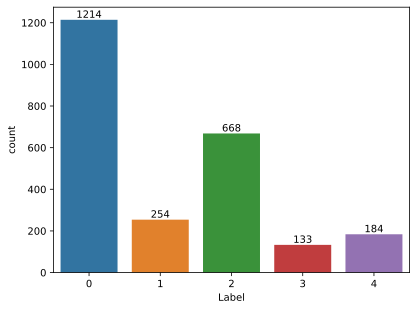

In [ ]:
ax = sns.countplot(x=train_label)
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
count_label = {1: 254,
               2: 668,
               3: 133,
               4: 184}

count_label

{1: 254, 2: 668, 3: 133, 4: 184}

In [ ]:
from torchvision.transforms import functional as F


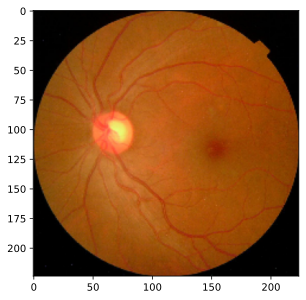

In [ ]:
plt.imshow(train_data.tensors[0][0].permute(1, 2, 0))

In [ ]:
from torchvision.transforms import functional as F
def transform_image(image):

    r_num = torch.randint(90, 180, size=[1]).item()
    image = F.rotate(image, r_num)

    if r_num % 3 == 0:
        image = F.hflip(image)

    elif r_num % 3 == 1:
        image = F.vflip(image)

    else:
        image = F.hflip(image)
        image = F.vflip(image)

    return image

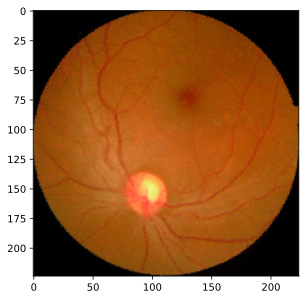

In [ ]:
plt.imshow(transform_image(train_data.tensors[0][0]).permute(1, 2, 0))

In [ ]:
count_label = {1: 254,
               2: 668,
               3: 133,
               4: 184}

for X, y in train_data:
    if y.item() == 1 and count_label[1] <= 1214:


Streaming output truncated to the last 5000 lines.
         [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]]]) tensor(2)
tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0196],
         [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0157, 0.0118],
         ...,
         [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0196],
         [0.0157, 0.0157, 0.0196,  ..., 0.0157, 0.0157, 0.0157],
         [0.0157, 0.0196, 0.0157,  ..., 0.0196, 0.0196, 0.0157]],

        [[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.01

KeyboardInterrupt: ignored